### 펫 인프라 시설 데이터 분석

#### 가설
1. 만족도가 높은 인프라시설이 많은 지역은 반려동물을 많이 키울것이다.
2. 반려동물 인프라 리뷰와 지역 유기율 간의 연관성

- 만족도가 높은 인프라시설이 많은 지역은 반려동물을 많이 키울것이다. 

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import mysql.connector
import koreanize_matplotlib 

%matplotlib inline

In [7]:
conn = mysql.connector.connect(
    host = " database-2.c3iym8yog7ht.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "pethub",
    password = "addinedu5",
    database = "pethub"
)

In [27]:
cursor = conn.cursor()
cursor.execute("""
                SELECT l.region, c.type, i.name, r.setiment, i.lat, i.lng
                from review r
                LEFT JOIN pet_infra i ON r.infra_id = i.id
                LEFT JOIN infra_category c ON i.category_id = c.id
                LEFT JOIN region_list l ON i.region_id = l.id;
                """)

result = cursor.fetchall()

df = pd.DataFrame(result, columns=["region", "type", "name", "setiment", "lat", "lng"])
df.head()

,region,type,name,setiment,lat,lng
0,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
1,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
2,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
3,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205
4,은평구,공원,은평구 반려견 놀이터,Y,37.49062,126.919205


- 지역별 시설 리뷰 수 시각화

In [54]:
region_review_counts = df.groupby(["region"])["name"].count().sort_values(ascending=False)

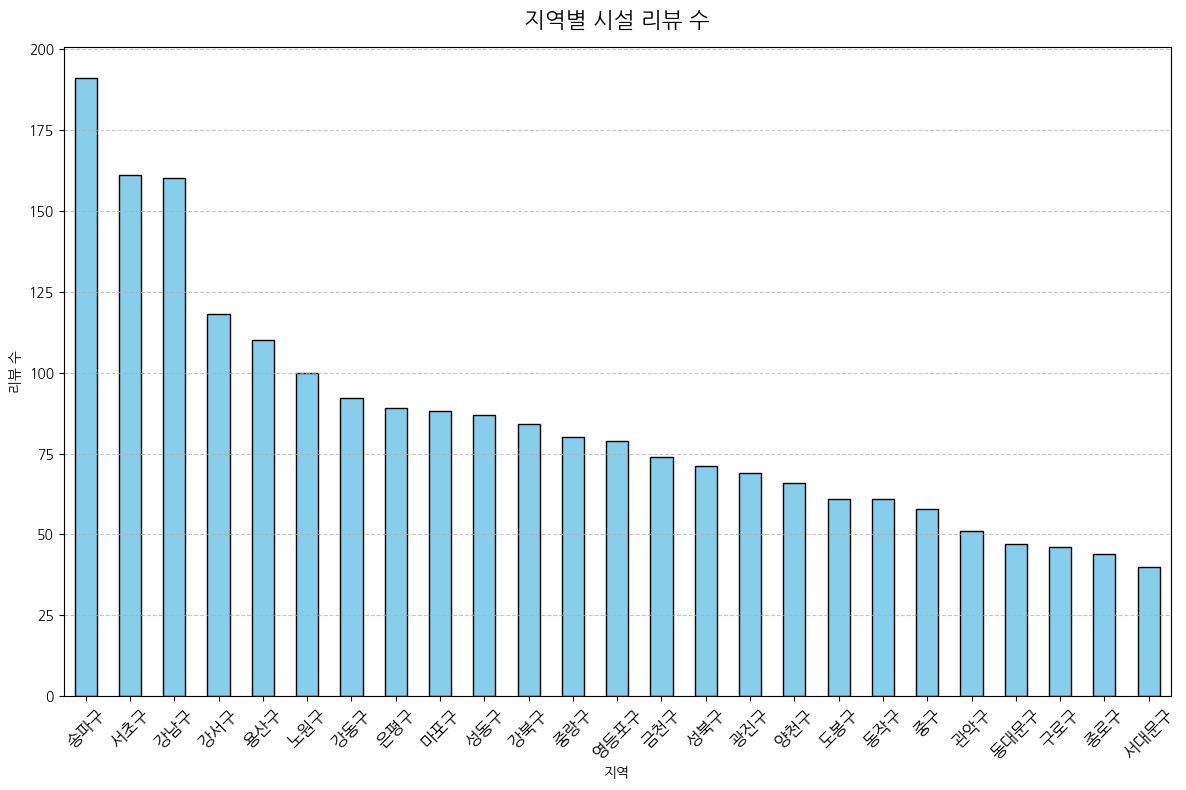

In [65]:
plt.figure(figsize=(12, 8))
region_review_counts.plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("지역별 시설 리뷰 수", fontsize=16, pad=15)
plt.xlabel("지역")
plt.ylabel("리뷰 수")
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

- 지역별 시설 긍정 리뷰 비율 시각화

In [70]:
region_sentiment = df.groupby(["region"])["setiment"].value_counts().unstack(fill_value=0)
region_sentiment.head()

setiment,N,Y
region,,
강남구,39,121
강동구,18,74
강북구,20,64
강서구,30,88
관악구,15,36


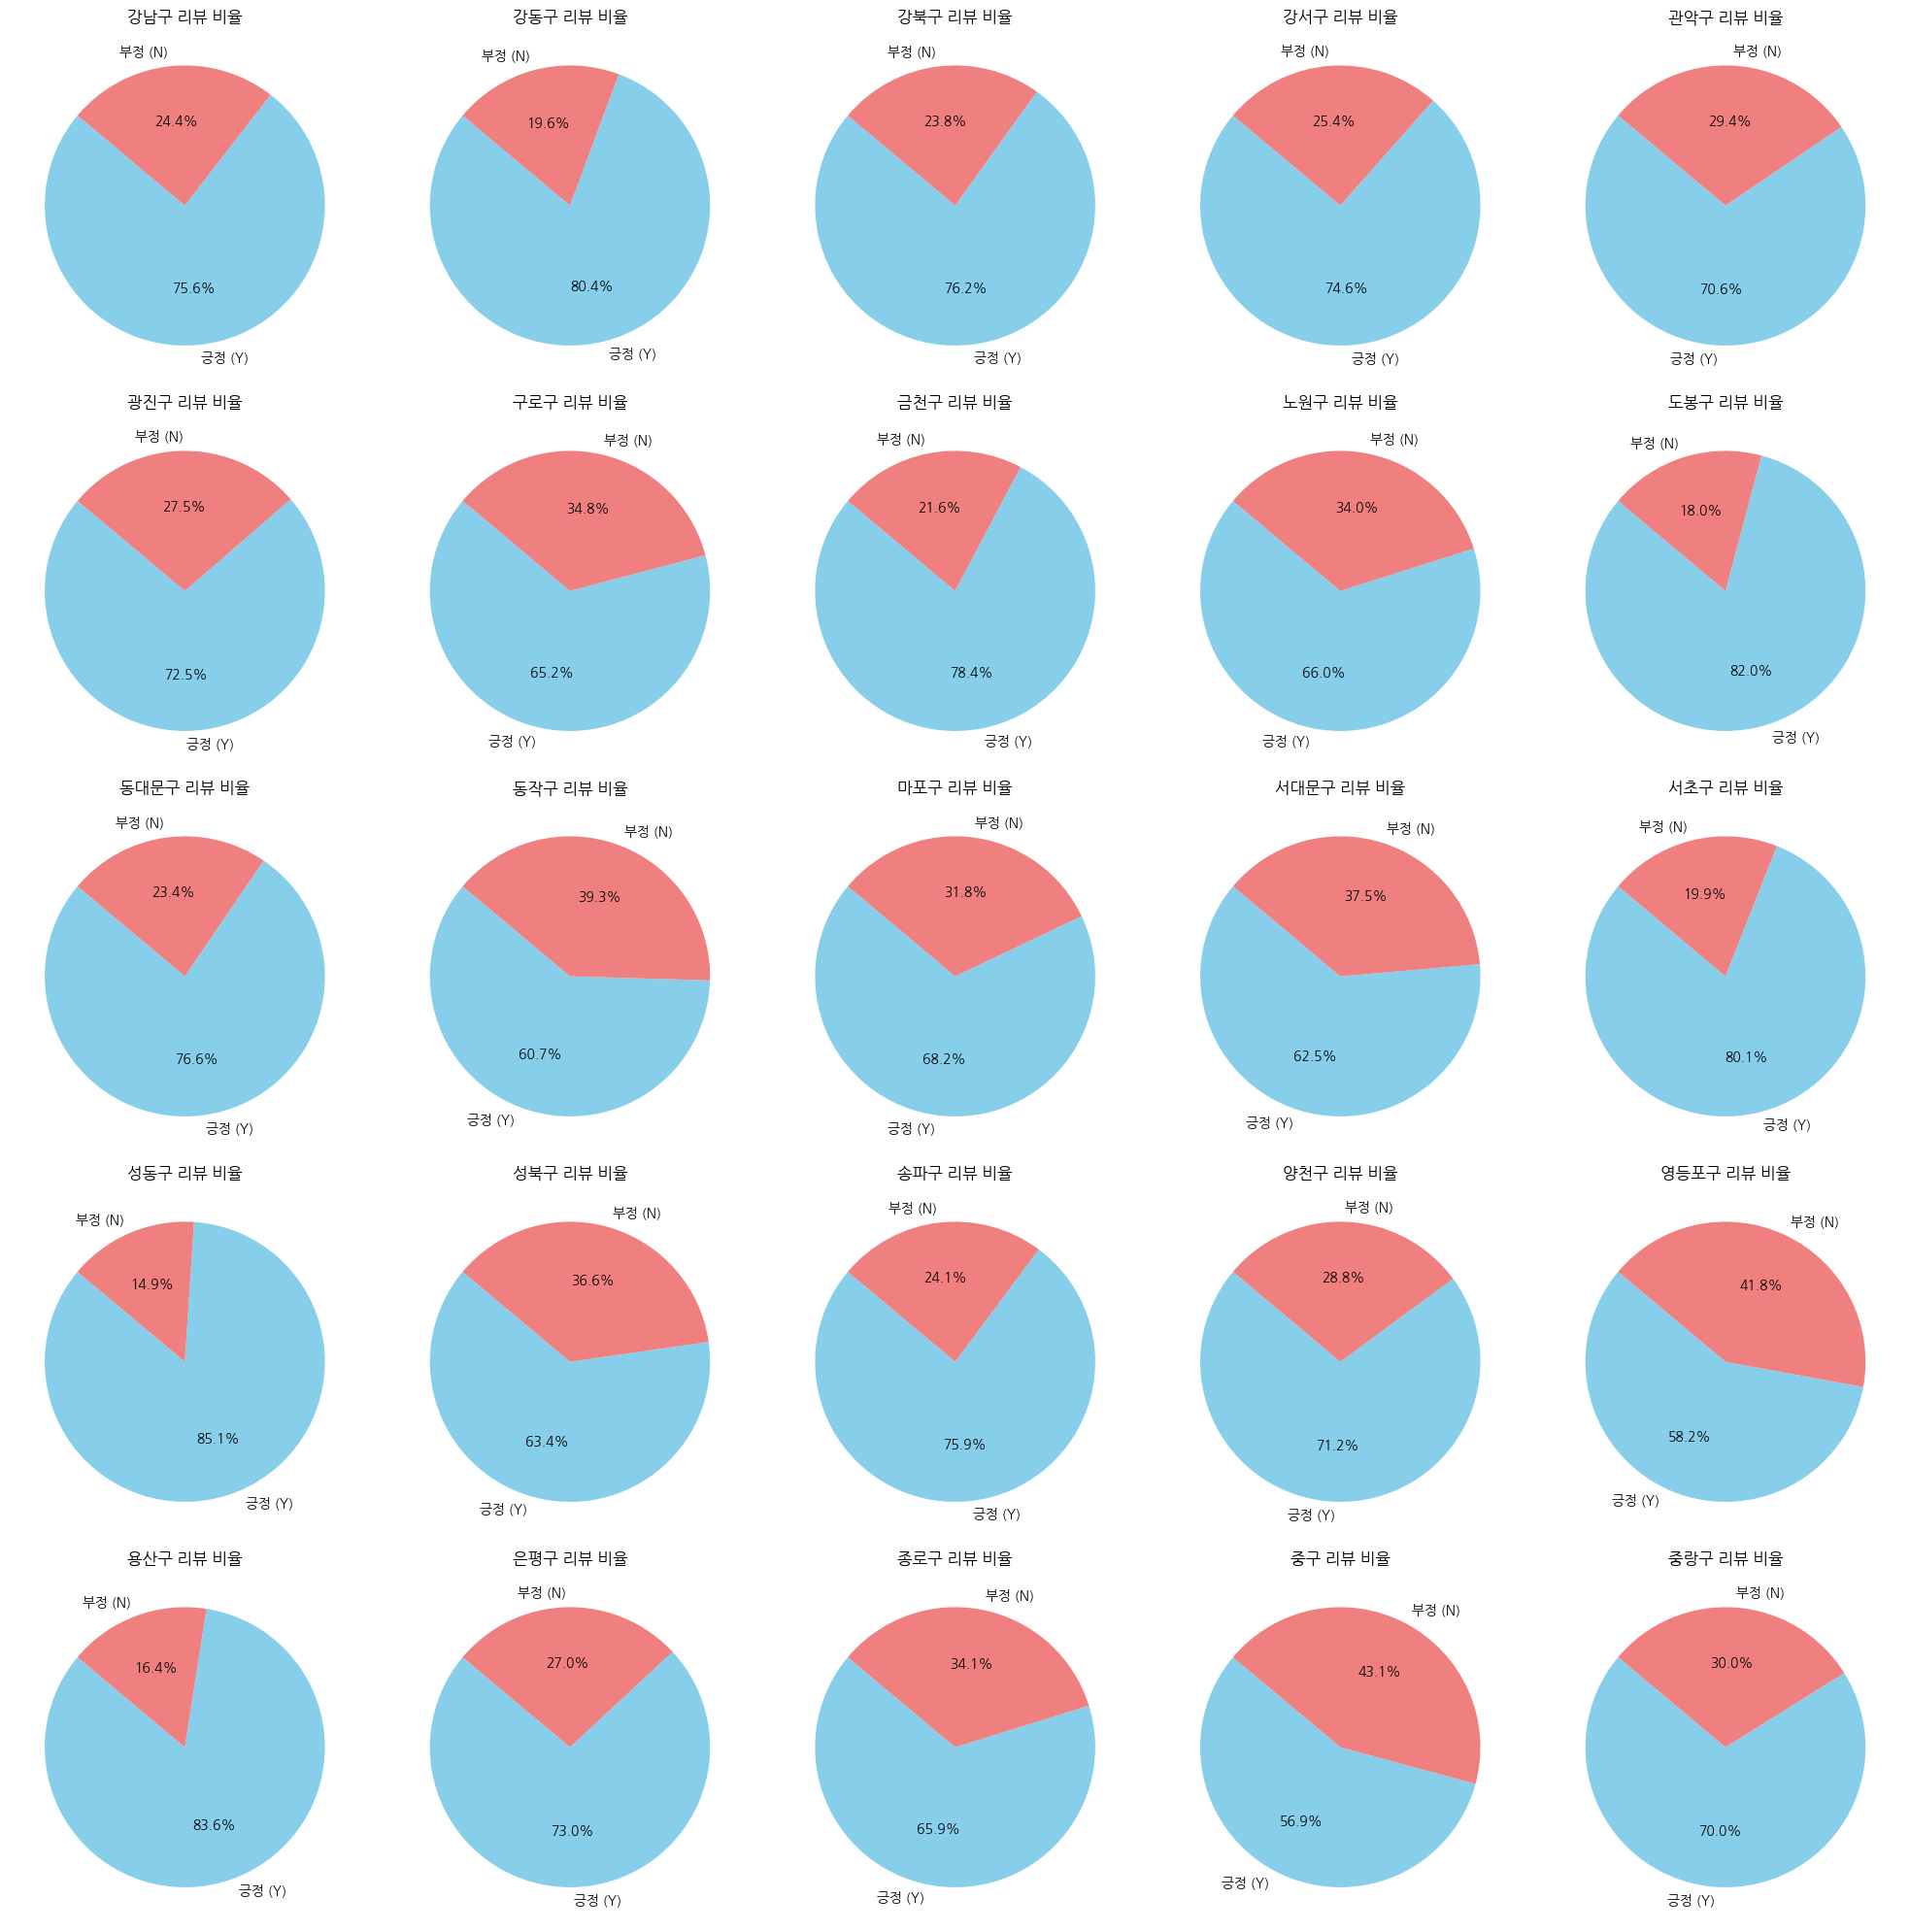

In [71]:
plt.figure(figsize=(20, 20))

# 각 지역에 대해 서브플롯 생성
for i, region in enumerate(region_sentiment.index):
    # 긍정(Y)과 부정(N) 리뷰 수
    positive_count = region_sentiment.loc[region, "Y"]
    negative_count = region_sentiment.loc[region, "N"]
    
    # 서브플롯
    plt.subplot(5, 5, i + 1)  # 5x5 그리드
    plt.pie(
        [positive_count, negative_count],
        labels=["긍정 (Y)", "부정 (N)"],
        autopct='%1.1f%%',
        startangle=140,
        colors=["skyblue", "lightcoral"]
    )
    plt.title(f"{region} 리뷰 비율", fontsize=12)

# 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

- 지역별 시설 긍정 리뷰 수 상위 10% 지도 시각화

In [93]:
from folium.plugins import MarkerCluster
# 긍정 리뷰 필터링
positive_reviews = df[df["setiment"] == "Y"]

# 지역별로 긍정 리뷰 상위 10개 추출
positive_reviews["positive_count"] = positive_reviews.groupby(["region", "name"])["setiment"].transform("count")

# 지역별로 긍정 리뷰 상위 10개 추출
top_10_per_region = positive_reviews.groupby("region").apply(lambda x: x.nlargest(10, "positive_count")).reset_index(drop=True)

# 지도 생성
map_center = [top_10_per_region["lat"].mean(), top_10_per_region["lng"].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# 마커 클러스터 추가
marker_cluster = MarkerCluster().add_to(m)

# 상위 시설 마커 추가
for _, row in top_10_per_region.iterrows():
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=f'<b>시설명:</b> {row["name"]}<br>'
              f'<b>지역:</b> {row["region"]}<br>'
              f'<b>긍정 리뷰 수:</b> {row["positive_count"]}',
        tooltip=f'{row["region"]} - {row["name"]}'
    ).add_to(marker_cluster)
m

/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_17315/1733862706.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_reviews["positive_count"] = positive_reviews.groupby(["region", "name"])["setiment"].transform("count")
/var/folders/1g/mh4r7xrj5gg2lcbjp9rv33fr0000gn/T/ipykernel_17315/1733862706.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_region = positive_reviews.groupby("region").apply(lambda x: x.nlargest(10, "posit